<a href="https://colab.research.google.com/github/afifaniks/TomatoLeafDiseaseDetection/blob/master/Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TLNet**: Tomato Leaf Disease Detection
Author: [Afif Al Mamun](https://afifaniks.me) <br>
Date: September, 2020

# Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGbs-DXtonpUenIlPZdGhXZqLAx3ymG_fIozrhr5ia2mm_jPnV7_lg
Mounted at /content/drive


In [2]:
!cp 'drive/My Drive/Leaf Disease/Dataset/Train_Dataset.zip' .

In [ ]:
!unzip Train_Dataset.zip

# Importing Modules

In [4]:
!pip install extra_keras_metrics

  Created wheel for extra-keras-metrics: filename=extra_keras_metrics-1.3.1-cp36-none-any.whl size=13091 sha256=69bf6de86742d073932703a61f8a238655fba43dd093ccc55a1649c9f8f4ddbb
  Stored in directory: /root/.cache/pip/wheels/48/f1/b4/a9f81578416b99274b6d5b34fdc92d9bd82b6be99efa965b17
Successfully built extra-keras-metrics


In [5]:
%tensorflow_version 1.15
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import keras
from keras.preprocessing import image
import numpy as np
import extra_keras_metrics as ekm
from keras.utils import plot_model
import json
from google.colab import files
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation

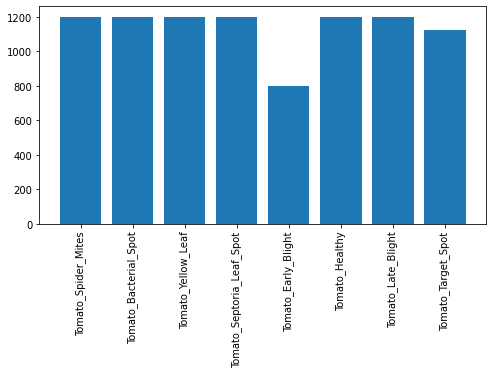

In [6]:
data_folder = 'Data_3/Train'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

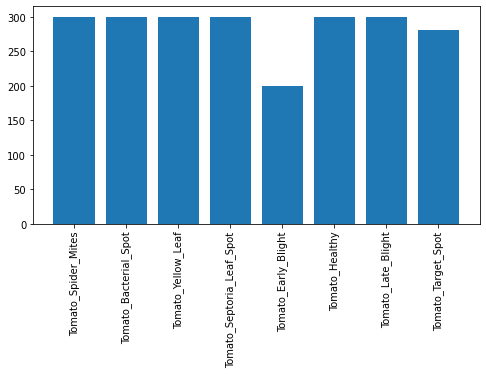

In [7]:
data_folder = 'Data_3/Test'
directory = os.listdir(data_folder)

file_counts = {}
for d in directory:
    file_counts[d] = len(os.listdir(os.path.join(data_folder, d)))
    
# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(file_counts.keys(), file_counts.values())
plt.xticks(rotation='vertical')
plt.show()

In [8]:
image = plt.imread('Data_3/Train/Tomato_Bacterial_Spot/0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_Bact.Sp 6254.JPG')
image.shape

(256, 256, 3)

In [9]:
# Image preprocessing
img_height = image.shape[0]
img_width = image.shape[1]

train_data_dir = 'Data_3/Train'
test_data_dir = 'Data_3/Test'

epochs = 50
batch_size = 20
batch_dim = -1

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
    batch_dim = 1
else:
    input_shape = (img_height, img_width, 3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, rotation_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = train_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 9124 images belonging to 8 classes.
Found 2280 images belonging to 8 classes.


In [10]:
train_size = len(train_generator.labels)
test_size = len(test_generator.labels)

# Model Preparation

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape, bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), bias_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01), activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=batch_dim))
model.add(Dropout(0.2))

model.add(Dense(8))
model.add(Activation(activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
______________________________________

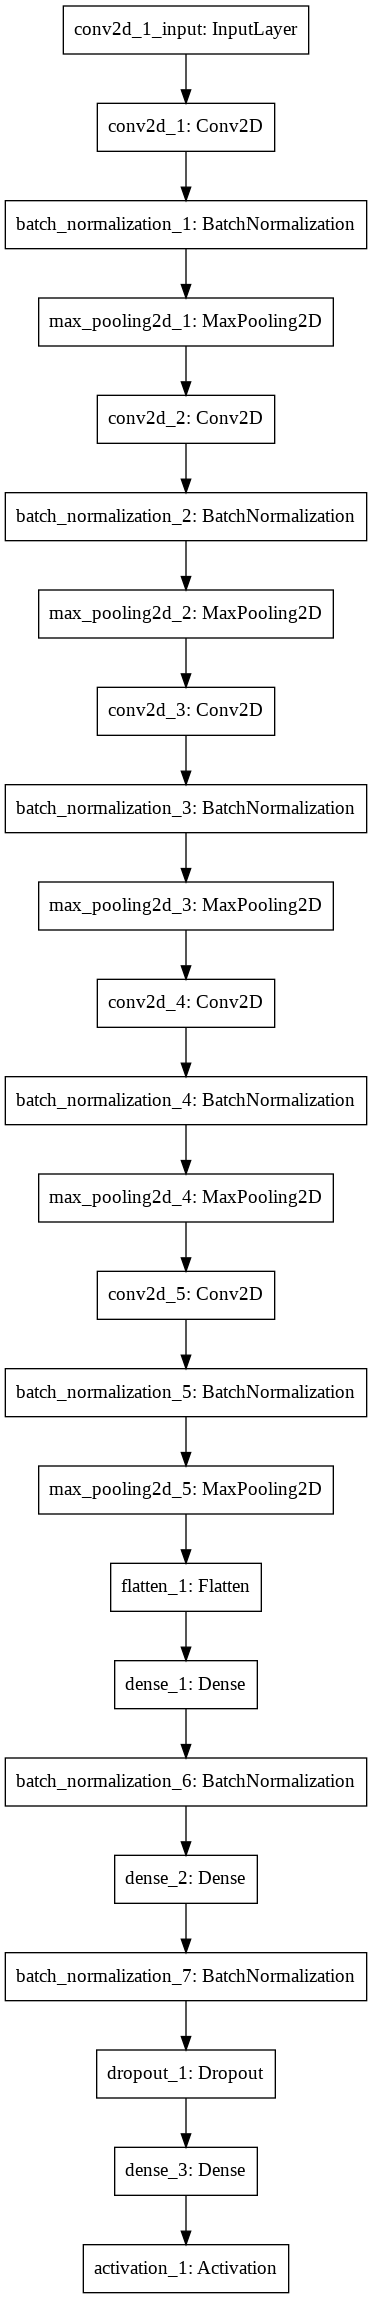

In [12]:
plot_model(model, to_file='model.png')

In [13]:
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('plants.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
metrics=["accuracy", ekm.precision, ekm.recall]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
results = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=np.ceil(train_size/batch_size), validation_data=test_generator, validation_steps=np.ceil(test_size/batch_size), callbacks=callbacks)

# Observations

KeyError: ignored

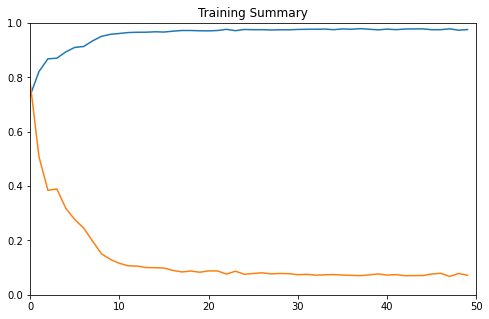

In [15]:
plt.figure(figsize=(8, 5))
plt.title("Training Summary")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['accuracy'], label="acc")
plt.plot(results.history['loss'], label="loss")
plt.plot(results.history['precision'], label="precision")
plt.plot(results.history['recall'], label="recall")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend();

KeyError: ignored

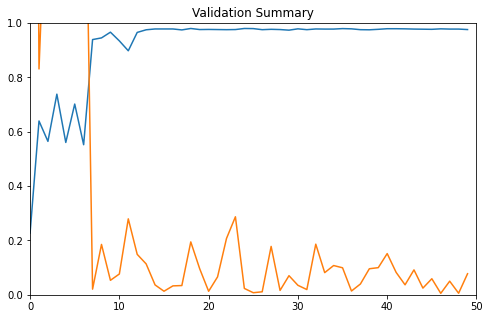

In [16]:
plt.figure(figsize=(8, 5))
plt.title("Validation Summary")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.plot(results.history['val_accuracy'], label="val_acc")
plt.plot(results.history['val_loss'], label="val_loss")
plt.plot(results.history['val_precision'], label="val_precision")
plt.plot(results.history['val_recall'], label="val_recall")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend();

# Downloads

In [ ]:
model_history = results.history

In [ ]:
# Download history
with open("history.json", "w") as f:
    json.dump(str(model_history), f)
files.download("history.json")
# Download model
files.download(plants.h5)

# Model Performance Evaluation

In [ ]:
!cp 'drive/My Drive/Leaf Disease/Dataset/Test_Dataset.zip' .
!unzip Test_Dataset.zip

In [ ]:
preds = []

test_data_dir = 'Test_Dataset'

dirs = sorted(os.listdir(test_data_dir))

for class_index in range(len(dirs)):
  class_path = os.path.join(test_data_dir, dirs[class_index])
  files = sorted(os.listdir(class_path))

  for f in files:
    image_path = os.path.join(class_path, f)
    image_pred = image.load_img(image_path, target_size=(img_height, img_width))

    image_pred = image.img_to_array(image_pred) / 256
    image_pred = np.expand_dims(image_pred, axis=0)

    result = model.predict_classes(image_pred)

    preds.append(result[0])
  
  class_index += 1


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), class_mode='categorical')
target_names = list(test_generator.class_indices.keys())
target_names

### Confusion Matrix

In [ ]:
con_mat = confusion_matrix(test_generator.classes, preds)
df_cm = pd.DataFrame(con_mat, columns=target_names, index=target_names)
sn.heatmap(df_cm, annot=True)

### Classification Report

In [ ]:
print(classification_report(test_generator.classes, preds, target_names=target_names))